# Store Sales Kaggle Seminar

## Feature Engineering

- forecast store sales on data from Corporación Favorita, a large Ecuadorian-based grocery retailer.
- 데이터 모판
- 결측치 채우기, 원핫인코딩, Feature Selection

결과 :

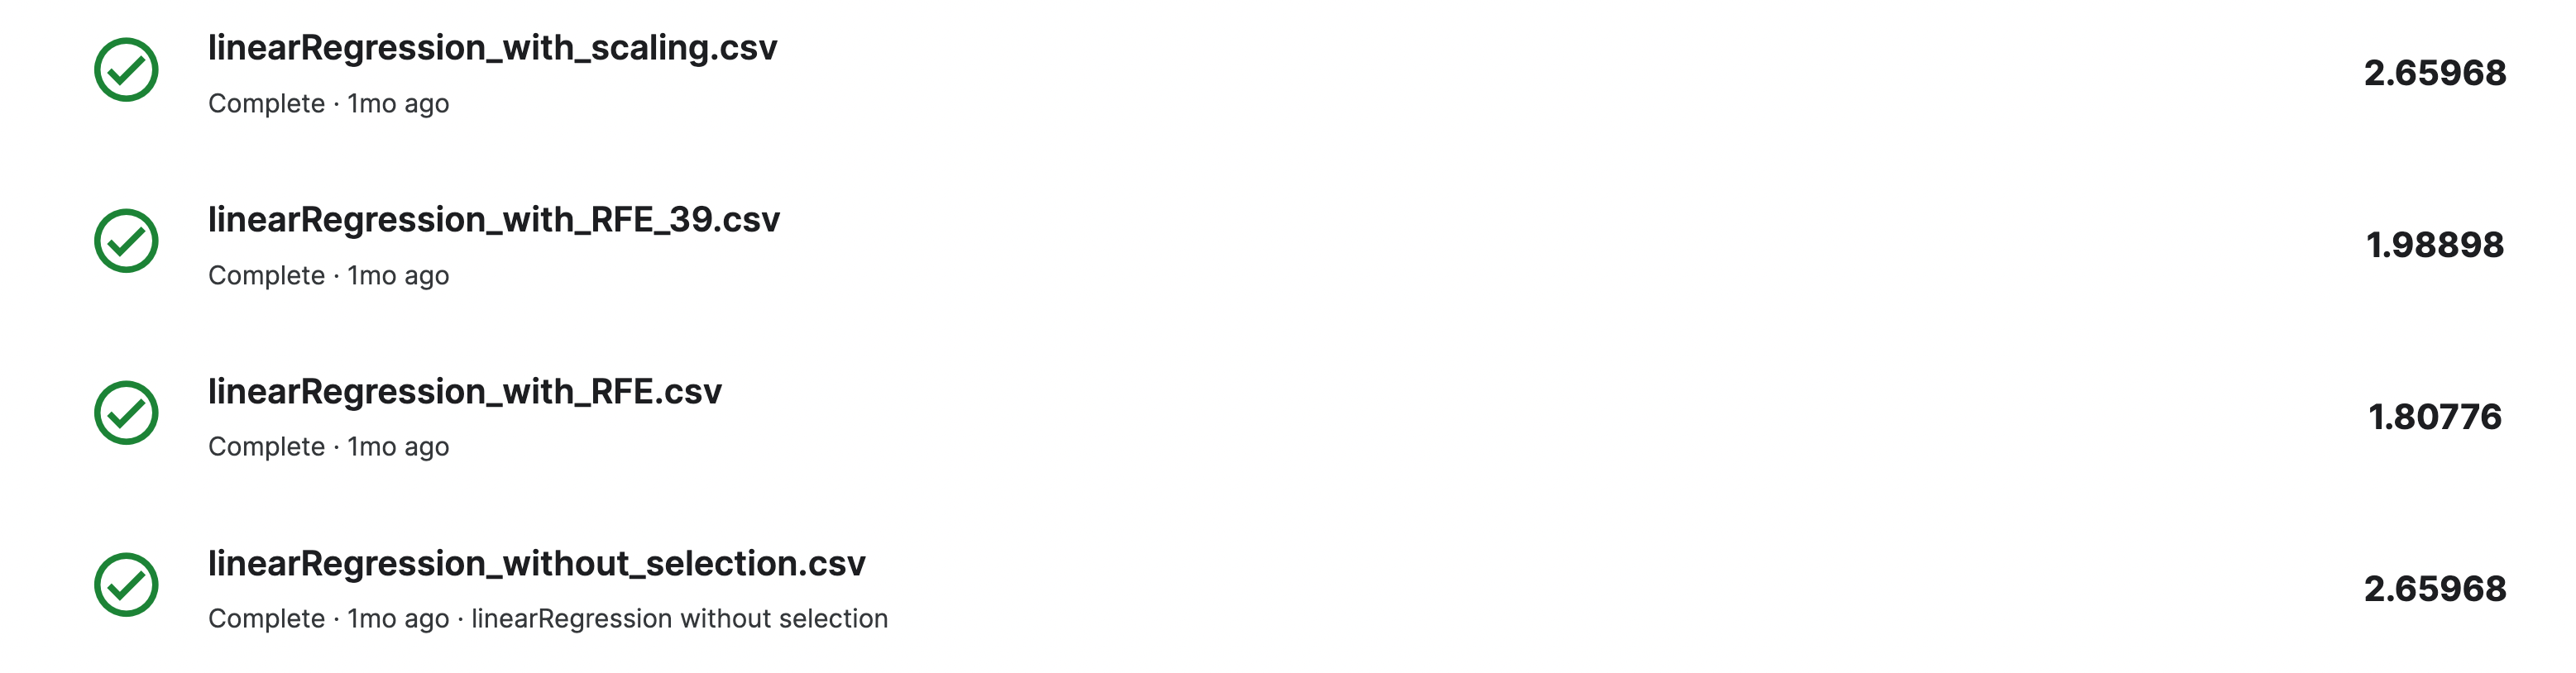

진행 과정

1. 모델 탐색
- 회귀 문제를 풀기 위한 다양한 모델 존재!
- 모델들의 default 성능 비교
- 가장 성능이 좋은 `모델 선정`

2. 하이퍼파라미터 튜닝
- 선정된 모델 파라미터 튜닝
- `feature selection`과 더불어 성능 향상 목표

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [4]:
DATA_DIR = "data/"

df = pd.read_csv(DATA_DIR + "RFE_df.csv")

number_of_train_dataset = df.sales.notnull().sum()

train = df.iloc[:,:-1][:number_of_train_dataset]
test = df.iloc[:,:-1][number_of_train_dataset:]
y_true = df['sales'][:number_of_train_dataset]

print("열 개수 : {0}, 데이터 개수 : {1}".format(len(df.columns.to_list()), len(df)))
print("columns : {0}".format(train.columns.to_list()))

열 개수 : 27, 데이터 개수 : 3029400
columns : ['family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY', 'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY', 'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_GROCERY I', 'family_HARDWARE', 'family_HOME APPLIANCES', 'family_LADIESWEAR', 'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_MAGAZINES', 'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS', 'family_PRODUCE', 'family_SCHOOL AND OFFICE SUPPLIES', 'holiday_type_Additional', 'holiday_type_Event', 'holiday_type_Holiday', 'holiday_type_Work Day', 'holiday_type_normal_day', 'type_A']


In [5]:
df.head()

,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_GROCERY I,...,family_PLAYERS AND ELECTRONICS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,holiday_type_Additional,holiday_type_Event,holiday_type_Holiday,holiday_type_Work Day,holiday_type_normal_day,type_A,sales
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.0


## 1. 모델 탐색

- 모델들의 default 성능 비교 (평가지표 : RMSLE + R-squared, MAE, RMSE)
- 모델의 종류

| name   | description |
| --------  |--------   |
| linearRegression |  | |
| Ridge |선형회귀 + L2 |
| Lasso  |선형회귀 + L1| 
| ElasticNet | 선형회귀 + L2 + L1|
| DecisionTreeRegressor  | |
| RandomForestRegressor  ||
| GradientBoostingRegressor| 앙상블 방법론 중 부스팅 계열 |
| XGBRegressor | GBM에서 파생된 트리 기반의 앙상블 학습 방법 |
| LGBMRegressor |XGB와 동일하되 리프중심트리 분할|

- 파이캐럿 ?

In [9]:
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))

def mae(y_true, y_pred):
    return mean_absolute_error(np.array(y_true), np.array(y_pred))

def rmsle(y_true, y_pred):
    log_actual_values = np.log1p(y_true)
    log_predicted_values = np.log1p(y_pred)
    squared_error = np.square(log_predicted_values - log_actual_values)
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

def get_model_avg_rmse(model, X_data, y_target):
    rmsle_scorer = make_scorer(rmsle)
    rmse_scorer = make_scorer(rmse)
    mae_scorer = make_scorer(mae)
    r2_scorer = make_scorer(r2)

    result = cross_validate(model, X_data, y_target, 
               scoring={'RMSLE' : rmsle_scorer, 'R-squared' : r2_scorer, 'MAE' : mae_scorer, 'RMSE': rmse_scorer}, 
              cv=5)
    mean_scores = {key:np.mean(result[key]) for key in result.keys()}
    return mean_scores

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), DecisionTreeRegressor(), RandomForestRegressor(), GradientBoostingRegressor(), LGBMRegressor(), XGBRegressor()]

for model in tqdm(models):
    result = get_model_avg_rmse(model, train, y_true)

-> 너무 시간이 오래 걸려 세션이 자꾸 다운됨
- main.py 로 하나하나 실행! + run.sh

In [6]:
from tqdm import tqdm
import os
import json

evaluate_dic = {'name':[], 'squared':[], 'MAE':[], 'RMSE':[], 'RMSLE':[]}

for file in [i for i in os.listdir(DATA_DIR) if i[-5:] == '.json']:
  with open(os.path.join(DATA_DIR, file), 'r') as f:
    result = json.load(f)

  evaluate_dic['name'].append(file[6:-5])
  evaluate_dic['squared'].append(result['test_R-squared'])
  evaluate_dic['MAE'].append(result['test_MAE'])
  evaluate_dic['RMSE'].append(result['test_RMSE'])
  evaluate_dic['RMSLE'].append(result['test_RMSLE'])

evaluate_table = pd.DataFrame(evaluate_dic, index=np.arange(0, 7))

그러나 xgboost, lightgbm 처참히 실패.

In [7]:
evaluate_table.sort_values('RMSLE', ascending=True)

,name,squared,MAE,RMSE,RMSLE
0,random_forest,5.027814e-01,237.315345,7.250183e+02,1.966537
5,decision_tree,5.026715e-01,237.323828,7.250613e+02,1.966559
6,Lasso,4.356102e-01,287.740707,7.842147e+02,2.715528
4,ridge,4.327144e-01,300.346123,7.843271e+02,2.737688
2,linear,-1.217094e+10,704671.099289,6.716962e+07,2.741519
1,gradient_boosting,5.091542e-01,252.985772,7.250601e+02,2.751164
3,elastic,4.791984e-02,491.841218,1.047243e+03,3.927558


##### 파이캐럿

- 수십개의 머신러닝 모델을 자동으로 돌려 가장 효과적인 모델과 파라미터를 찾아준다
- 파라미터 튜닝도 함께 해주기 떄문에 원하는 모델을 골라 사용 가능하다

In [20]:
from pycaret.regression import *

setup_rgs = setup(data=df[:number_of_train_dataset], target='sales')
top5 = compare_models(sort='RMSLE', n_select=5)

,Description,Value
0,session_id,4412
1,Target,sales
2,Original Data,"(3000888, 27)"
3,Missing Values,False
4,Numeric Features,0
5,Categorical Features,26
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(2100621, 26)"


IntProgress(value=0, description='Processing: ', max=99)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,02:51:33
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,K Neighbors Regressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,236.9359,668453.4121,817.5081,0.4501,1.9707,2.7901,46.4690
par,Passive Aggressive Regressor,239.9507,666608.1901,816.3705,0.4516,2.1716,3.5481,1.7120
lasso,Lasso Regression,279.6906,593807.2812,770.4862,0.5115,2.8160,11.8314,9.6770
lar,Least Angle Regression,292.4628,592972.5827,769.9441,0.5122,3.0936,14.8530,0.3410
lr,Linear Regression,292.4377,592973.4312,769.9447,0.5122,3.0949,14.8719,0.9980
br,Bayesian Ridge,292.4456,592971.3963,769.9433,0.5122,3.0951,14.8723,3.4710
ridge,Ridge Regression,292.5148,592972.3875,769.9439,0.5122,3.0957,14.8874,0.3130
omp,Orthogonal Matching Pursuit,342.9150,706973.1310,840.7441,0.4184,3.5015,21.8460,0.2690
en,Elastic Net,489.7367,1141954.2750,1068.5769,0.0604,3.9480,40.4000,3.6340
llar,Lasso Least Angle Regression,512.7199,1215319.9866,1102.3731,-0.0000,4.0011,43.3810,0.2680


/Users/lee/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 531234816.0, tolerance: 230133152.0
  model = cd_fast.enet_coordinate_descent(
/Users/lee/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 239665152.0, tolerance: 229588256.0
  model = cd_fast.enet_coordinate_descent(
/Users/lee/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 340525056.0, tolerance: 229677440.0
  model = cd_fast.enet_coordinate_descent(
/Users/lee/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_coordina

xgboost, lightgbm 모델 실행이 불가능하여 끝까지 돌리지 못했다..

In [ ]:
top1 = create_model('huber')
tuned_top1 = tune_model(top1, optimize = 'RMSLE', n_iter = 10)
final_model = finalize_model(tuned_top1) # 세팅된 파라미터로 학습
pred = predict_model(final_model, data=test)

# 제출 코드
idx = (df[number_of_train_dataset:].index).tolist()
submission_columns = ["id", "sales"]
submission_df = pd.DataFrame([idx, pred]).T
submission_df.columns = submission_columns

for col_name in submission_columns:
  submission_df[col_name] = submission_df[col_name].astype(int)

submission_df.to_csv(os.path.join("data/result/", "pycaret.csv"), index=False)

## 2. 하이퍼파라미터 튜닝

### trial 0

모델 `random_forest`으로 선정!

In [17]:
rf = RandomForestRegressor()
rf.fit(train, y_true)
rf_pred = rf.predict(test)

# 제출 코드
idx = (df[number_of_train_dataset:].index).tolist()
submission_columns = ["id", "sales"]
submission_df = pd.DataFrame([idx, rf_pred]).T
submission_df.columns = submission_columns

for col_name in submission_columns:
  submission_df[col_name] = submission_df[col_name].astype(int)

submission_df.to_csv(os.path.join("data/result/", "rf_initial_pred.csv"), index=False)

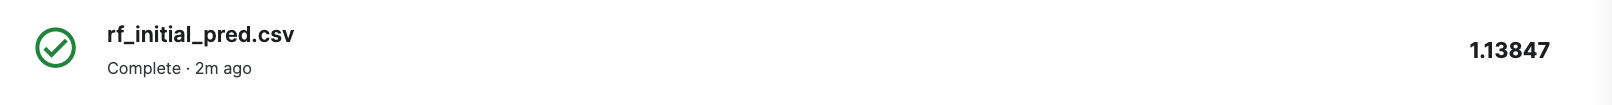


linearRegression Score (RFE_26) : 1.80776

> RandomForestRegressor Score (default) : 1.13847

### trial 1

In [8]:
from sklearn.model_selection import GridSearchCV

def grid_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_squared_error', cv=3,  verbose=10, n_jobs=4)

    grid_model.fit(train, y_true)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model

In [10]:
from sklearn.ensemble import RandomForestRegressor

params = {'criterion': ['squared_error', 'absolute_error'], # mse, mae
                'max_depth': [2, 5, 10],
                'min_samples_leaf' : [2, 5, 10],
}

rf = RandomForestRegressor()
trial1_results = grid_params(rf, params)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV 2/3; 1/18] START criterion=squared_error, max_depth=2, min_samples_leaf=2...
[CV 1/3; 1/18] START criterion=squared_error, max_depth=2, min_samples_leaf=2...[CV 1/3; 2/18] START criterion=squared_error, max_depth=2, min_samples_leaf=5...

[CV 3/3; 1/18] START criterion=squared_error, max_depth=2, min_samples_leaf=2...
[CV 3/3; 1/18] END criterion=squared_error, max_depth=2, min_samples_leaf=2;, score=-978943.652 total time=  37.5s
[CV 1/3; 1/18] END criterion=squared_error, max_depth=2, min_samples_leaf=2;, score=-429878.382 total time=  37.6s
[CV 2/3; 2/18] START criterion=squared_error, max_depth=2, min_samples_leaf=5...
[CV 1/3; 2/18] END criterion=squared_error, max_depth=2, min_samples_leaf=5;, score=-429642.755 total time=  37.7s
[CV 3/3; 2/18] START criterion=squared_error, max_depth=2, min_samples_leaf=5...
[CV 2/3; 1/18] END criterion=squared_error, max_depth=2, min_samples_leaf=2;, score=-652383.317 total time=  37.7s
[CV 1/3; 3/18] START criterion=squared_error, max_dept

KeyboardInterrupt: 

##### 처참히 실패

local

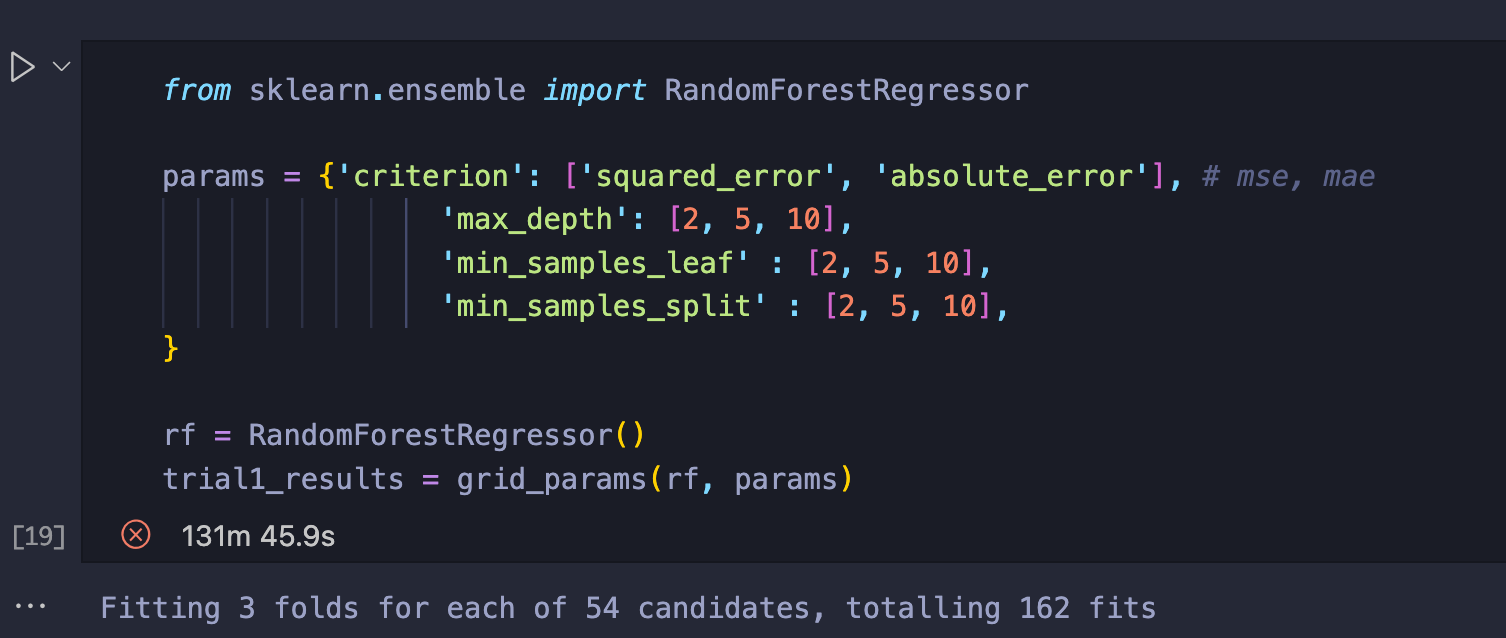
- 어느순간 학습이 중단, 속도 ...

은빈 언니의 컴퓨터 (16개의 CPU)

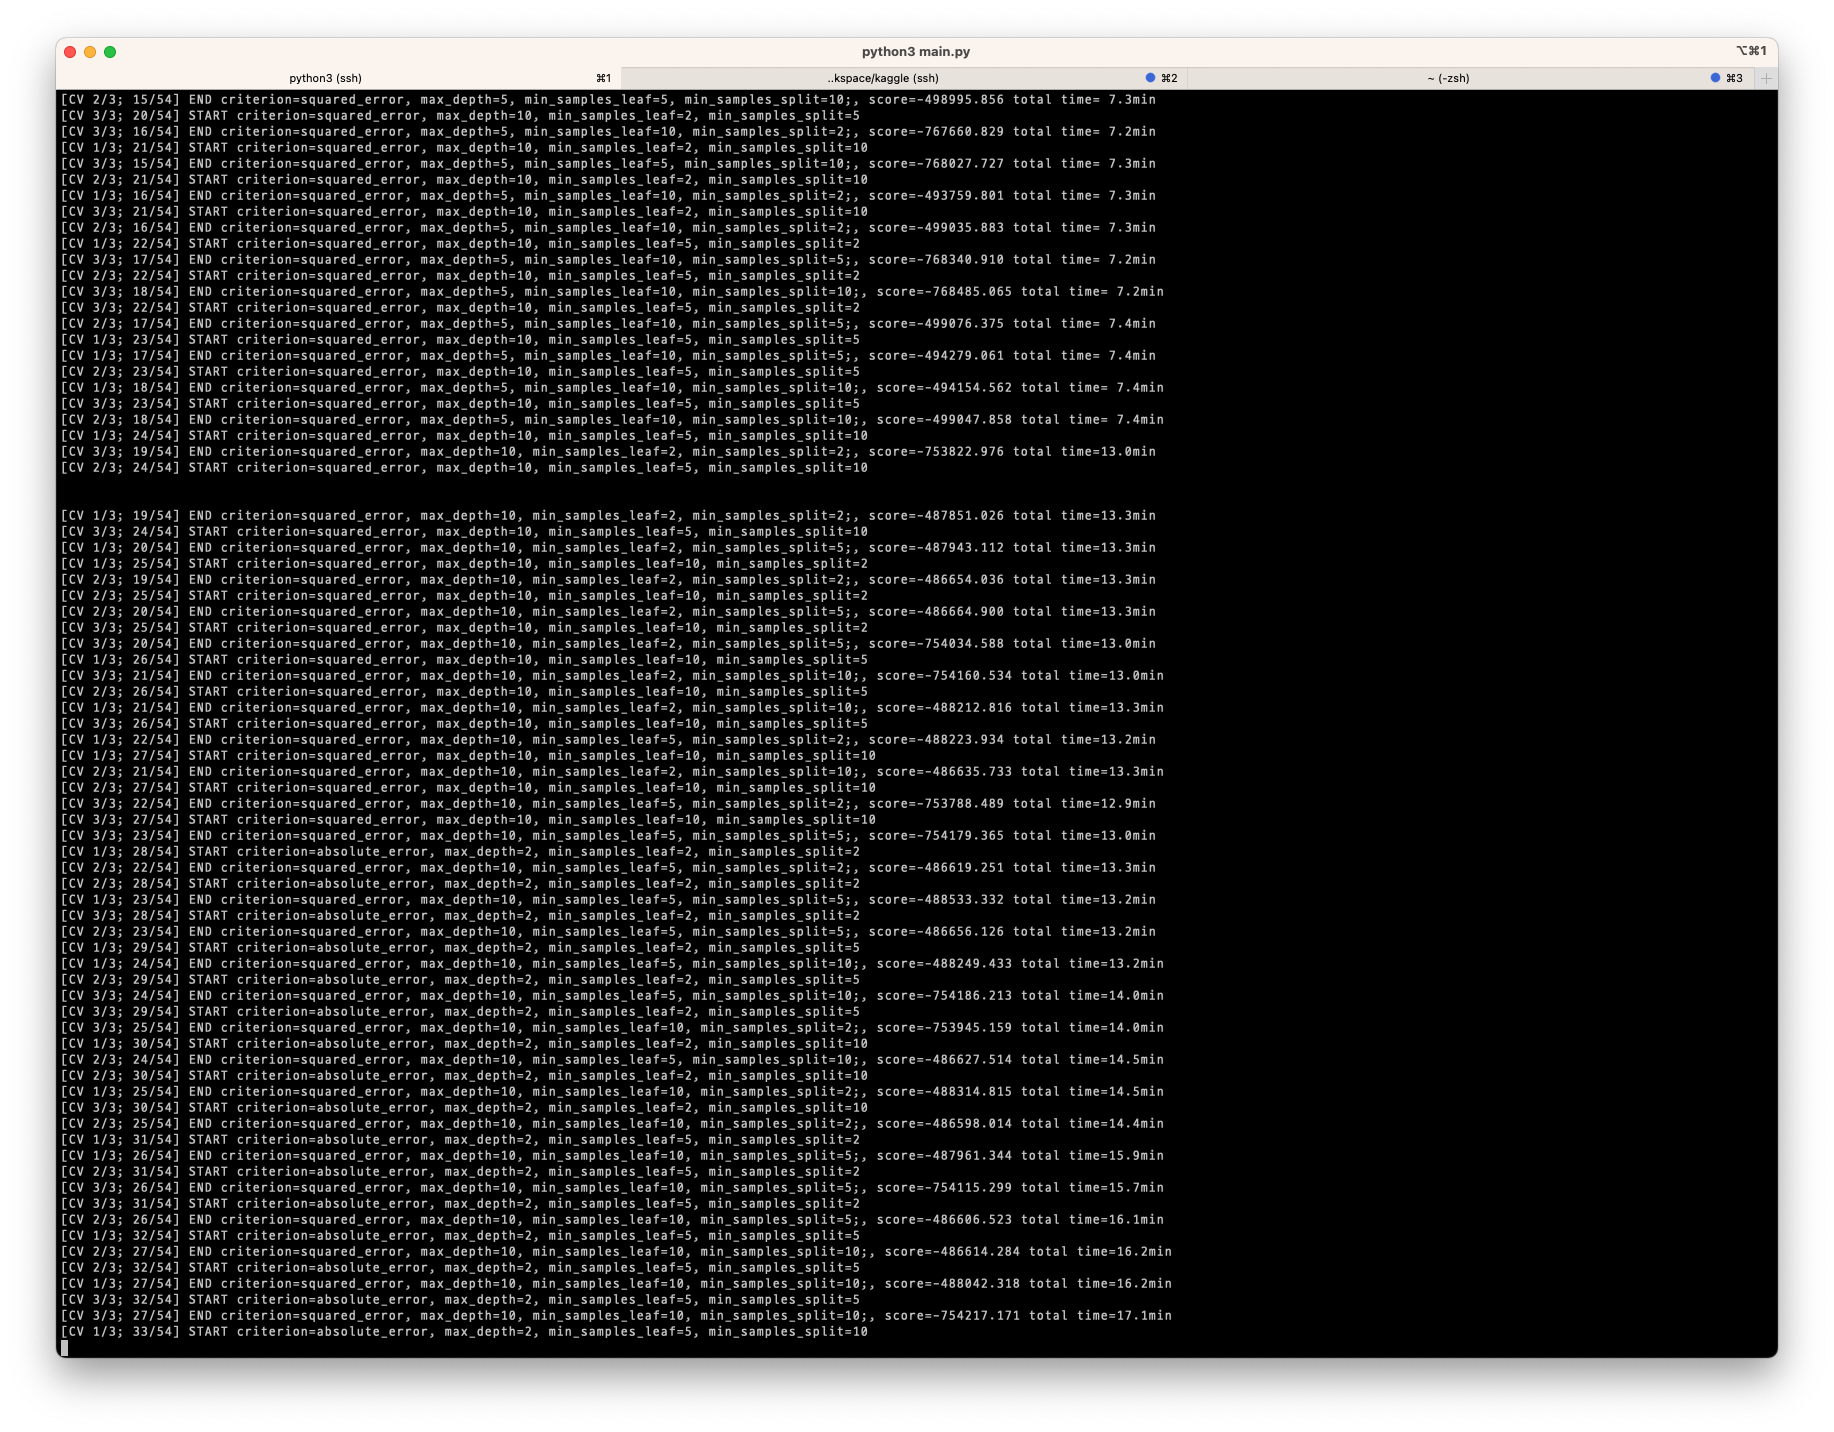
- 속도 진전 없음

코랩
- 데이터를 올리고, 코드를 돌릴 때마다 런타임 아웃
- read_csv에서부터 문제가 많았으나 마지막으로 돌렸을 땐 제대로 돌아가는 것 같다

backend AI
- 유일한 희망
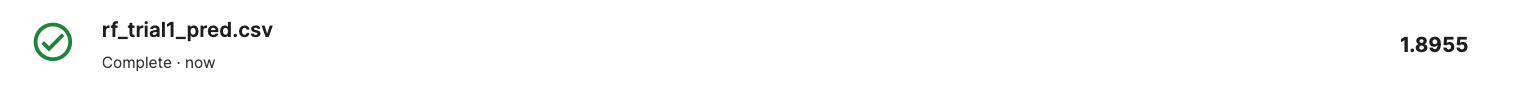

In [ ]:
trial1_rf = trial1_results.best_estimator_
trial1_pred = trial1_rf.predict(test)
trial1_pred

In [ ]:
# 제출 코드
idx = (df[number_of_train_dataset:].index).tolist()
submission_columns = ["id", "sales"]
submission_df = pd.DataFrame([idx, trial1_pred]).T
submission_df.columns = submission_columns

for col_name in submission_columns:
  submission_df[col_name] = submission_df[col_name].astype(int)

submission_df.to_csv("rf_trial1_pred.csv", index=False)

### trial 2

### additional

In [ ]:
all_df = pd.read_csv(DATA_DIR + "all_of_df.csv")

all_train = all_df.iloc[:,:-1][:number_of_train_dataset]
all_test = all_df.iloc[:,:-1][number_of_train_dataset:]
all_y_true = all_df['sales'][:number_of_train_dataset]

print("열 개수 : {0}, 데이터 개수 : {1}".format(len(df.columns.to_list()), len(df)))
print("columns : {0}".format(train.columns.to_list()))

In [ ]:
all_df.head()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

add_rf = RandomForestRegressor().fit(all_train, all_y_true)
importance = np.abs(add_rf.coef_)
feature_names = np.array(all_df.feature_names)
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances")
plt.show()

In [ ]:
from sklearn.feature_selection import SelectFromModel # 통계학을 사용하여 모델 없애주는 것

sfm = SelectFromModel(add_rf, threshold='1.5 * median').fit(all_train, all_y_true)
print("Features selected by SelectFromModel: "
      f"{feature_names[sfm.get_support()]}")

In [ ]:
selected_feature = feature_names[sfm.get_support()]
sfm_all_df = all_df[selected_feature]

sfm_train = sfm_all_df.iloc[:,:-1][:number_of_train_dataset]
sfm_test = sfm_all_df.iloc[:,:-1][number_of_train_dataset:]
sfm_y_true = sfm_all_df['sales'][:number_of_train_dataset]

sfm_rf = RandomForestRegressor().fit(sfm_train, sfm_y_true)
sfm_rf